In [2]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

In [3]:
# 读取数据（确保正确处理空格）
df = pd.read_csv('D:\\2024test.csv', skipinitialspace=True)  # 跳过初始空格

# 检查 radiation 列
print("是否存在 NaN:", df["radiation"].isna().any())
print("是否存在 Inf:", np.isinf(df["radiation"]).any())
print("唯一值示例:", df["radiation"].unique()[:10])  # 查看前10个唯一值
print("最大值:", df["radiation"].max())
print("最小值:", df["radiation"].min())
# 移除空格并转换为 float
df["radiation"] = df["radiation"].astype(str).str.strip().replace("", np.nan).astype(float)

是否存在 NaN: False
是否存在 Inf: False
唯一值示例: [  0.    23.68 357.38 582.58 706.73 763.16 766.68 717.16 591.71 371.44]
最大值: 993.52
最小值: 0.0


In [4]:
# 读取数据（确保正确处理空格）
df = pd.read_csv('D:\\2025test.csv', skipinitialspace=True)  # 跳过初始空格

# 检查 radiation 列
print("是否存在 NaN:", df["radiation"].isna().any())
print("是否存在 Inf:", np.isinf(df["radiation"]).any())
print("唯一值示例:", df["radiation"].unique()[:10])  # 查看前10个唯一值
print("最大值:", df["radiation"].max())
print("最小值:", df["radiation"].min())
# 移除空格并转换为 float
df["radiation"] = df["radiation"].astype(str).str.strip().replace("", np.nan).astype(float)

是否存在 NaN: False
是否存在 Inf: False
唯一值示例: [  0.    22.45 546.64 667.86 714.28 704.38 667.82 524.63 266.39   0.75]
最大值: 1077.88
最小值: 0.0


In [5]:
import pandas as pd
import optuna
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# 加载训练集和验证集数据（2024年数据）
train_val_data = pd.read_csv('D:\\2024test.csv')
X_train_val = train_val_data.drop(columns=['O3'])
y_train_val = train_val_data['O3']

# 加载独立的测试集数据（2025年数据）
test_data = pd.read_csv('D:\\2025test.csv')
X_test = test_data.drop(columns=['O3'])
y_test = test_data['O3']

# 从训练+验证集中划分训练集和验证集（90%训练，10%验证）
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.1,  # 10%作为验证集
    random_state=42
)

# 检查划分比例
print("="*50)
print("数据集划分比例：")
print(f"训练集 (2024年部分): {len(X_train)}条记录 ({len(X_train)/len(X_train_val):.1%})")
print(f"验证集 (2024年部分): {len(X_val)}条记录 ({len(X_val)/len(X_train_val):.1%})")
print(f"测试集 (2025年完整数据): {len(X_test)}条记录")
print("="*50)

数据集划分比例：
训练集 (2024年部分): 28813条记录 (90.0%)
验证集 (2024年部分): 3202条记录 (10.0%)
测试集 (2025年完整数据): 10329条记录


In [6]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1  # 使用所有CPU核心
    }

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# 参数优化阶段
print("="*50)
print("开始随机森林参数优化...")
print("="*50)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# 获取并显示最佳参数
best_params = study.best_params
best_params.update({
    'random_state': 42,
    'n_jobs': -1
})

print("\n" + "="*50)
print(f"{'最佳参数':^50s}")
print("="*50)
for key, value in best_params.items():
    print(f"{key:>20s}: {value}")
print("="*50 + "\n")

# 最终模型训练
print("训练最终随机森林模型...")
random_model = RandomForestRegressor(**best_params)
random_model.fit(
    X_train_val,  # 使用全部2024年数据训练
    y_train_val
)

# 测试集评估（2025年数据）
y_pred = random_model.predict(X_test)

# 计算评估指标
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 打印结果
print("\n" + "="*50)
print(f"{'随机森林模型在2025年测试集上的表现':^50s}")
print("="*50)
print(f"{'评估指标':^20s} | {'值':^15s} | {'描述':^20s}")
print("-"*50)
print(f"{'RMSE':>20s} | {rmse:.4f} | 均方根误差")
print(f"{'MSE':>20s} | {mse:.4f} | 均方误差")
print(f"{'MAE':>20s} | {mae:.4f} | 平均绝对误差")
print(f"{'R²':>20s} | {r2:.4f} | 决定系数")
print("="*50)

[I 2025-07-10 16:25:30,183] A new study created in memory with name: no-name-8c9d4a32-22b9-422d-89c6-44bd3bc89fc3


开始随机森林参数优化...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-10 16:25:33,297] Trial 0 finished with value: 12.575372388341828 and parameters: {'n_estimators': 317, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 0.3678310863941878, 'bootstrap': True}. Best is trial 0 with value: 12.575372388341828.
[I 2025-07-10 16:25:44,784] Trial 1 finished with value: 14.005834606246836 and parameters: {'n_estimators': 411, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 0.9566464417607661, 'bootstrap': False}. Best is trial 0 with value: 12.575372388341828.
[I 2025-07-10 16:25:49,495] Trial 2 finished with value: 15.247337792420984 and parameters: {'n_estimators': 424, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 11, 'max_features': 0.5914161628629496, 'bootstrap': True}. Best is trial 0 with value: 12.575372388341828.
[I 2025-07-10 16:25:54,299] Trial 3 finished with value: 12.351543406211679 and parameters: {'n_estimators': 247, 'max_depth': 12, 'min_samples_split':

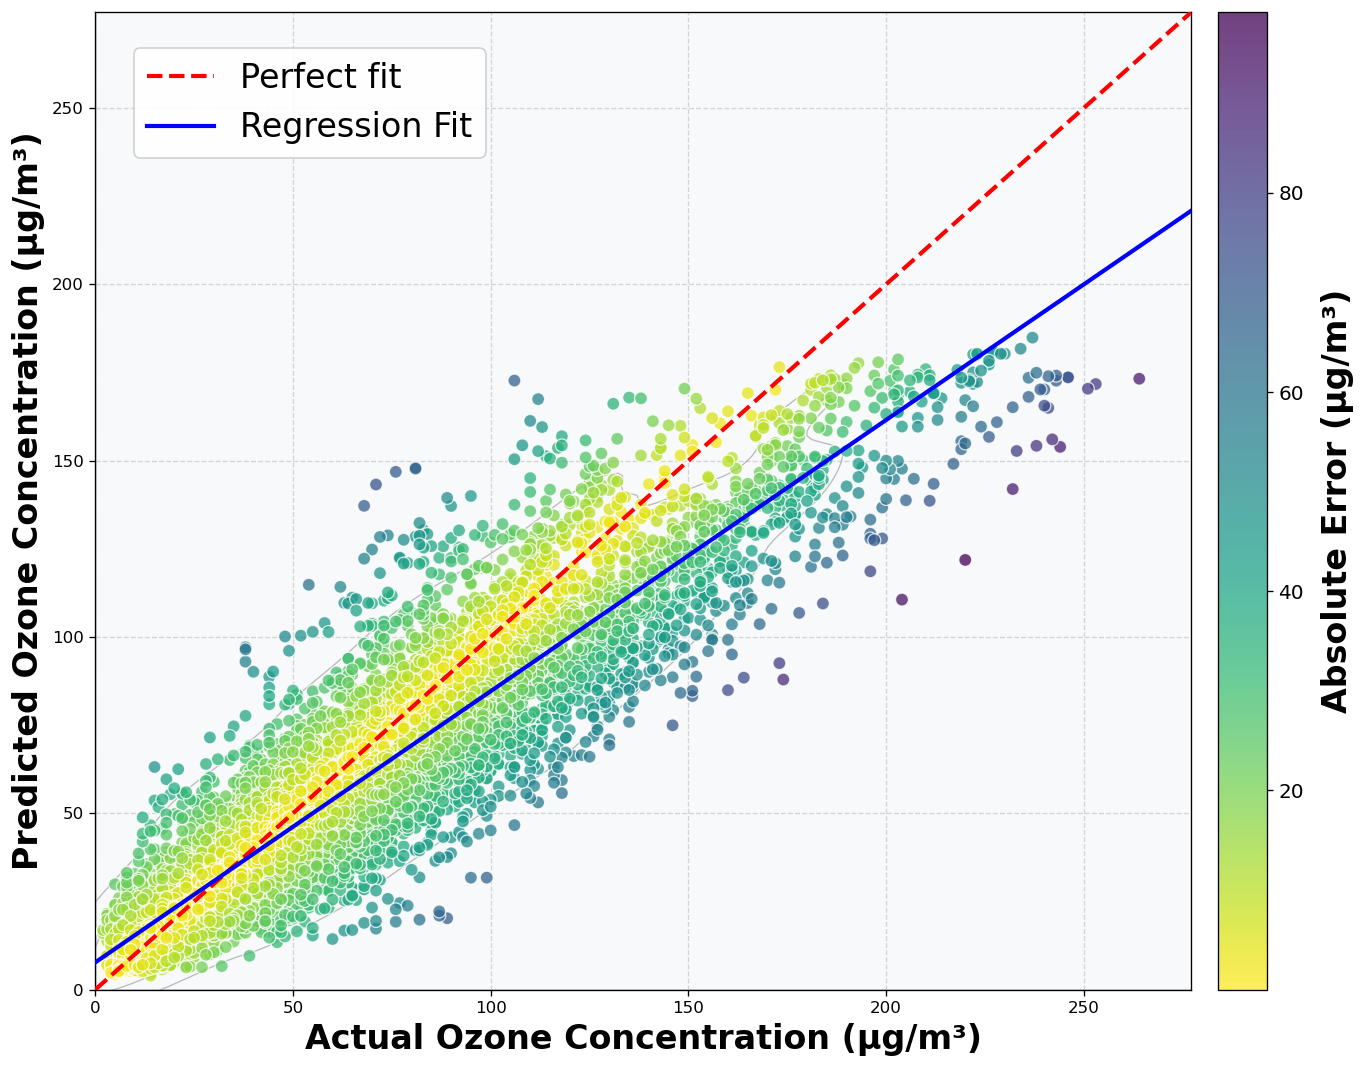

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from matplotlib.patches import Arc

# 设置全局绘图参数
plt.figure(figsize=(12, 9), dpi=120)
plt.rcParams['font.family'] = 'DejaVu Sans'  # 使用支持中文的字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 在测试集上进行预测
y_pred = random_model.predict(X_test)

# 1. 创建散点图（专业风格）
scatter = plt.scatter(y_test, y_pred, 
                    c=np.abs(y_test - y_pred),  # 颜色表示误差大小
                    cmap='viridis_r',  # 反转色图，使高误差更明显
                    alpha=0.75, 
                    s=60, 
                    edgecolor='w', 
                    linewidth=0.8,
                    zorder=3)  # 设置图层顺序

# 2. 添加完美拟合线（红色虚线）
min_val = min(y_test.min(), y_pred.min(), 0) * 0.95  # 确保包含0点
max_val = max(y_test.max(), y_pred.max()) * 1.05
perfect_fit, = plt.plot([min_val, max_val], [min_val, max_val], 
                      'r--', linewidth=2.5, label='Perfect fit', zorder=5)

# 3. 添加回归拟合线（蓝色实线）
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
reg_line = slope * np.array([min_val, max_val]) + intercept  # 使用相同的坐标范围
reg_fit, = plt.plot([min_val, max_val], reg_line, 
                  'b-', linewidth=2.5, 
                  label='Regression Fit', zorder=5)

# 计算两条线之间的夹角
m1 = 1.0  # 完美拟合线斜率 (y = x)
m2 = slope  # 回归线斜率

# 避免除零错误
if abs(1 + m1 * m2) > 1e-6:
    angle_rad = abs(math.atan((m2 - m1) / (1 + m1 * m2)))
    angle_deg = abs(math.degrees(angle_rad))
else:
    angle_deg = 90.0  # 线垂直

# 4. 添加颜色条
cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label('Absolute Error (μg/m³)', fontsize=20, labelpad=10, fontweight='bold')
cbar.ax.tick_params(labelsize=12)


# 6. 设置主图标签和标题
plt.xlabel('Actual Ozone Concentration (μg/m³)', fontsize=20, fontweight='bold')
plt.ylabel('Predicted Ozone Concentration (μg/m³)', fontsize=20, fontweight='bold')
#plt.title('Random Forest Optimized Model Performance', fontsize=16, pad=15)

# 7. 添加图例（位置优化）
plt.legend(loc='upper left',bbox_to_anchor=(0.02, 0.98), fontsize=20, frameon=True, framealpha=0.9)

# 8. 设置网格和背景
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('#f8f9fa')

# 9. 设置坐标轴范围
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# 10. 添加数据点密度等高线（可选）
# 如果数据点密集，可以添加等高线显示密度分布
if len(y_test) > 100:
    sns.kdeplot(x=y_test, y=y_pred, 
                levels=5, color='gray', 
                alpha=0.5, linewidths=0.8)

# 12. 确保坐标轴从(0,0)开始
plt.axhline(0, color='gray', linestyle='-', alpha=0.3, zorder=0)
plt.axvline(0, color='gray', linestyle='-', alpha=0.3, zorder=0)

# 优化布局并保存
plt.tight_layout()
plt.savefig('random_forest_performance.png', dpi=300, bbox_inches='tight')
plt.show()